In [34]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from imblearn import over_sampling
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [35]:
'''
Prepare data for classifier
    - Use discretized citation count as label
    - Drop non-numeric columns
'''

# Load data
data = pd.read_csv('Data/ads_data_clean.csv')
data_DTC = data.copy()

# Create label
citation_count_label = []
for i in range(len(data)):
    row = data.iloc[i]
    #label = 'Verylow' if row['citation_count'] < -0.5 else 'Low' if row['citation_count'] < 0 else 'Med' if row['citation_count'] < 1 else 'High' if row['citation_count'] < 2.5 else 'Veryhigh'
    label = 'LowCC' if row['citation_count'] <= -0.27 else 'LowMedCC' if  row['citation_count'] <= 0.16 else 'HighMedCC' if row['citation_count'] <= 1.03 else 'HighCC' if row['citation_count'] <= 2.25 else 'VeryHighCC'
    citation_count_label.append(label)
data_DTC['citation_count_label'] = citation_count_label
data_DTC.drop(columns=['citation_count'], inplace=True)

# Drop non-numeric columns
data_DTC.drop(columns=['bibcode', 'doi', 'aff', 'bibstem', 'arxiv_class'], inplace=True)
display(data_DTC)

,author_count,year,read_count,download_count,journal_rank,citation_count_label
0,-0.342659,0.399746,15.781133,0.691080,-0.718169,LowCC
1,0.411490,0.191319,5.439945,4.147883,-0.405034,VeryHighCC
2,-0.342659,1.025027,1.420615,-0.940852,-0.207874,LowCC
3,0.746667,-0.642389,6.174266,3.974185,-0.405034,VeryHighCC
4,-0.334280,-1.267670,3.746686,2.386458,-0.526809,VeryHighCC
...,...,...,...,...,...,...
987,-0.346849,-1.684524,-0.096406,0.183506,-0.613791,LowMedCC
988,-0.149932,-1.892951,0.557356,0.672878,-0.422430,LowMedCC
989,-0.296572,-1.892951,0.151535,0.377487,-0.439827,LowMedCC
990,-0.330090,-1.892951,0.280474,0.536624,3.312001,LowMedCC


Text(0.5, 0, 'Citation Count')

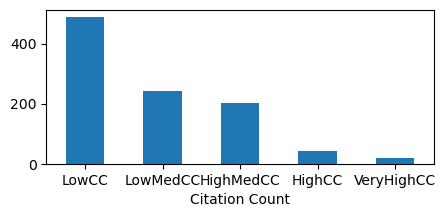

In [36]:
'''
Look at distribution of labels
Shows that need to apply oversampling to training set to help with imbalance 
'''

plt.figure(figsize=(5, 2))
data_DTC['citation_count_label'].value_counts().plot.bar(rot=0)
plt.xlabel('Citation Count')

Text(0, 0.5, 'Count')

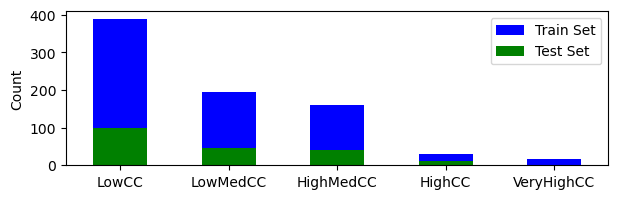

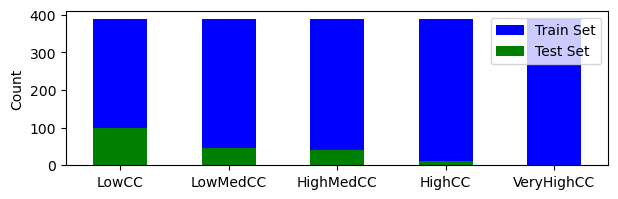

In [37]:
'''
TTS DT Dataset
'''

# Split into X and y
X = data_DTC.drop(columns=['citation_count_label'])
y = data_DTC['citation_count_label']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
plt.figure(figsize=(7, 2))
y_train.value_counts().plot.bar(rot=0, color='b', label='Train Set')
y_test.value_counts().plot.bar(rot=0, color='g', label='Test Set')
plt.legend()
plt.ylabel('Count')

# Apply oversampling to training set
sm = over_sampling.RandomOverSampler(random_state=0)
X_train, y_train = sm.fit_resample(X_train, y_train)
pickle.dump([X_train, y_train, X_test, y_test], open('Data/DT_TT', 'wb')) # Just for project requirenments 
plt.figure(figsize=(7, 2))
y_train.value_counts().plot.bar(rot=0, color='b', label='Train Set')
y_test.value_counts().plot.bar(rot=0, color='g', label='Test Set')
plt.legend()
plt.ylabel('Count')

### Decision Trees

In [17]:
'''
Find best DT hyperparameters
'''

res = pd.DataFrame(columns=['criterion', 'max_depth', 'accuracy'])
criterions = ['gini', 'entropy', 'log_loss']
max_depths = [5,10, 15,20]
for criterion in criterions:
    for depth in max_depths:
        model = DecisionTreeClassifier(criterion=criterion, max_depth=depth)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = metrics.accuracy_score(y_test, preds)
        res = res.append({'criterion': criterion, 'max_depth': depth, 'accuracy': acc}, ignore_index=True)
res = res.sort_values(by='accuracy', ascending=False)
display(res)


,criterion,max_depth,accuracy
1,gini,10,0.753769
3,gini,20,0.718593
2,gini,15,0.708543
4,entropy,5,0.698492
8,log_loss,5,0.698492
9,log_loss,10,0.698492
0,gini,5,0.693467
6,entropy,15,0.688442
7,entropy,20,0.688442
10,log_loss,15,0.688442


In [9]:
print(y_test.value_counts())
cm = metrics.confusion_matrix(y_test, preds, labels=['LowCC', 'LowMedCC', 'HighCC', 'HighMedCC', 'VeryHighCC'])
print(cm)
print(np.sum(cm, axis=1))

LowCC         98
LowMedCC      47
HighMedCC     41
HighCC        12
VeryHighCC     1
Name: citation_count_label, dtype: int64
[[81 15  0  2  0]
 [ 4 27  2 14  0]
 [ 0  4  1  6  1]
 [ 3 10  5 23  0]
 [ 0  0  1  0  0]]
[98 47 12 41  1]


Overall accuracy for criterion = gini, Max Depth of 10: 75.38%
Overall accuracy for criterion = gini, Max Depth of 5: 69.35%
Overall accuracy for criterion = log_loss, Max Depth of 10: 66.33%


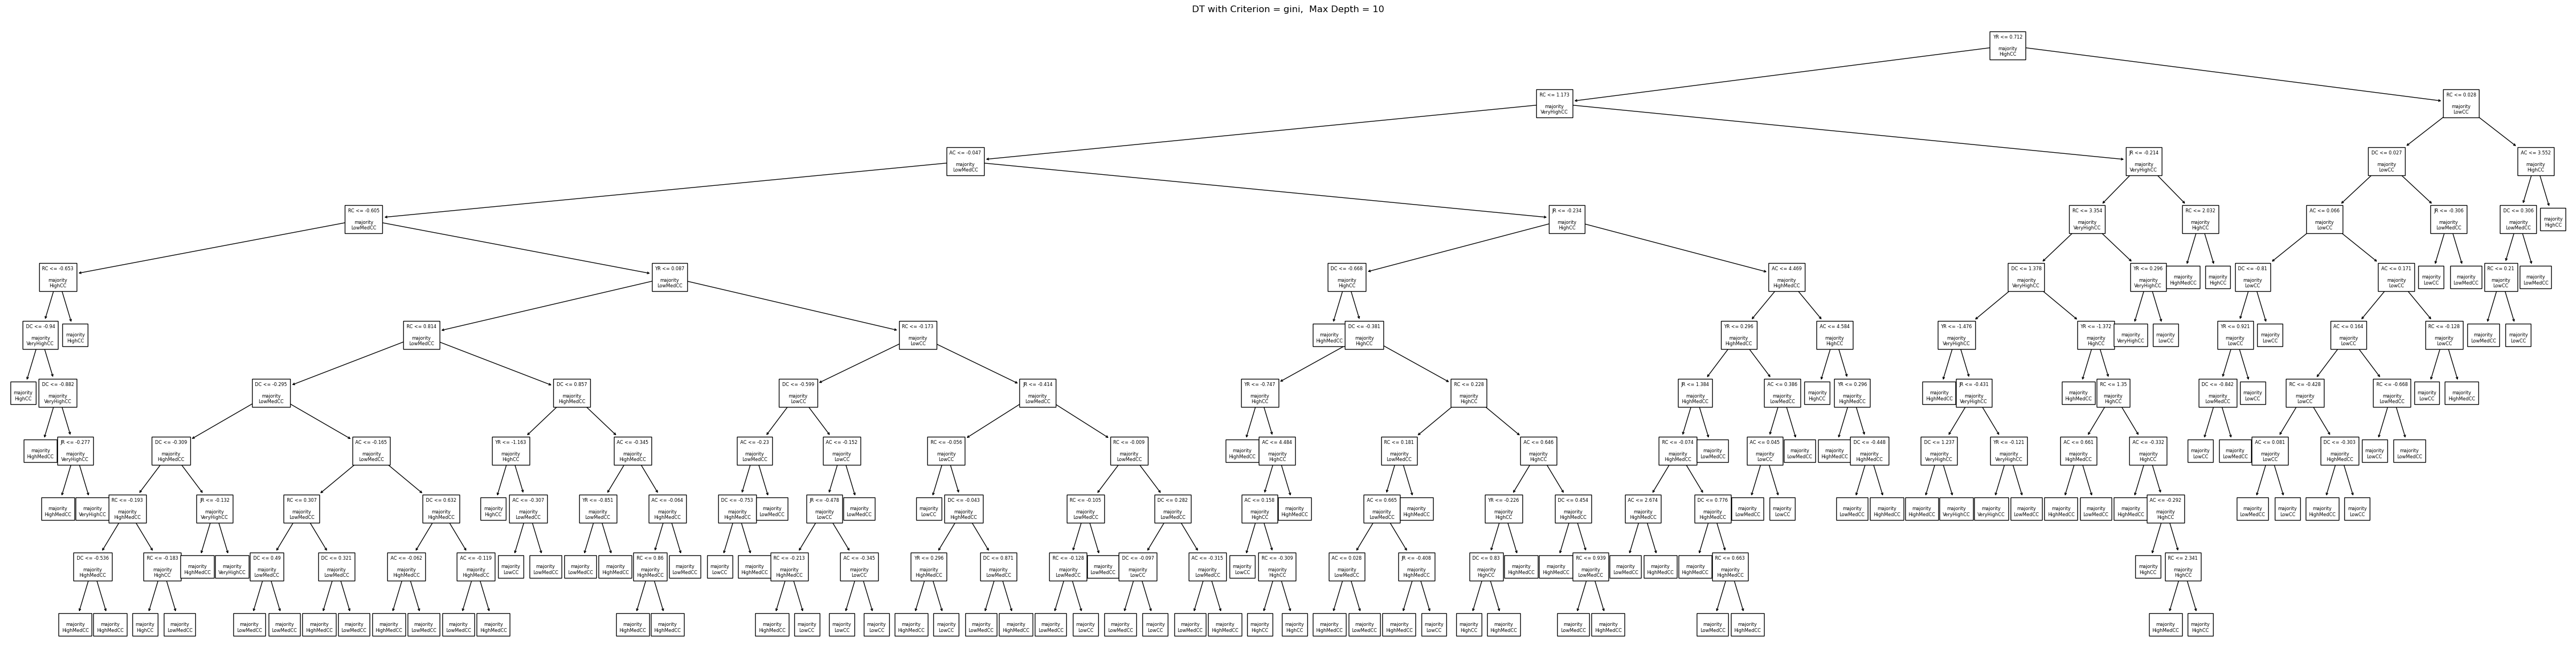

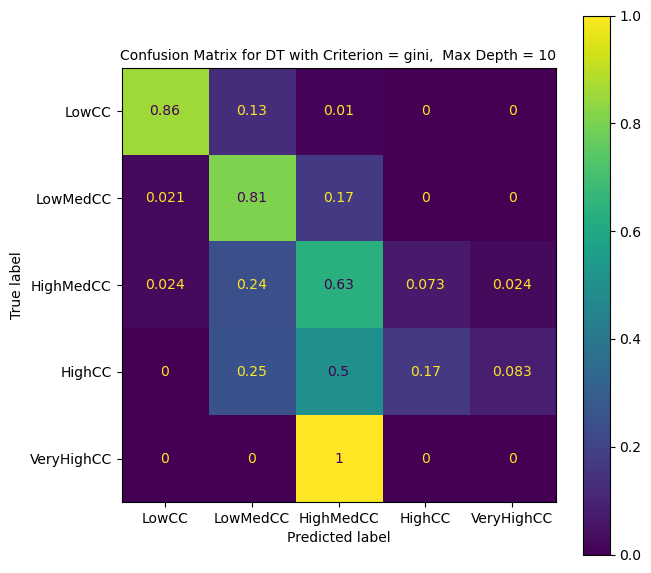

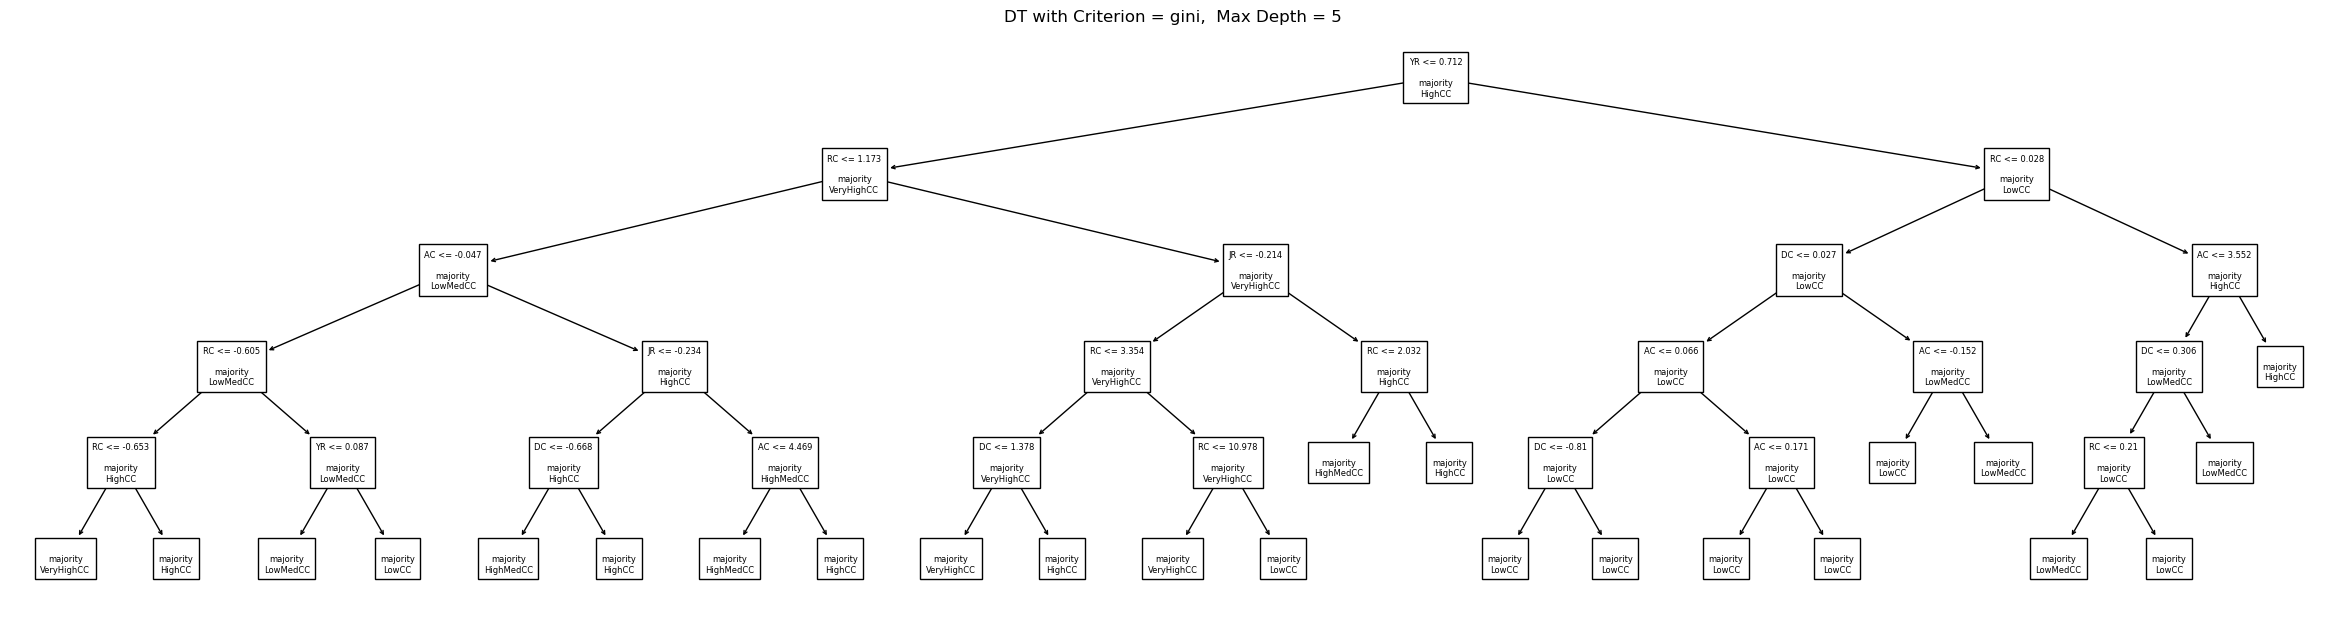

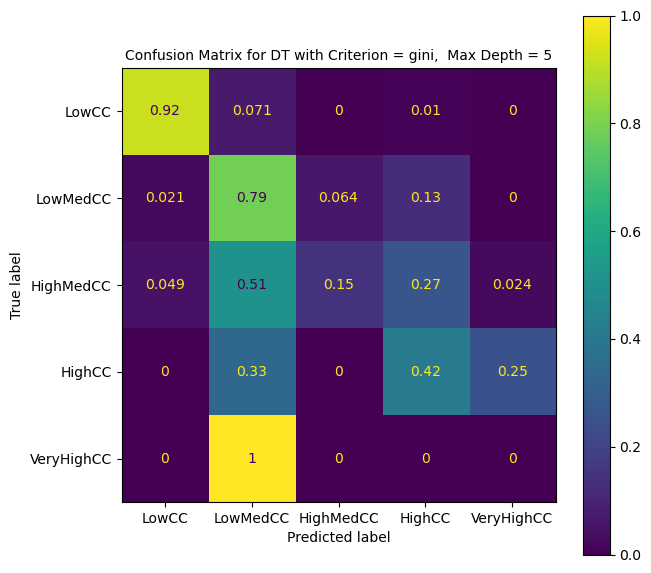

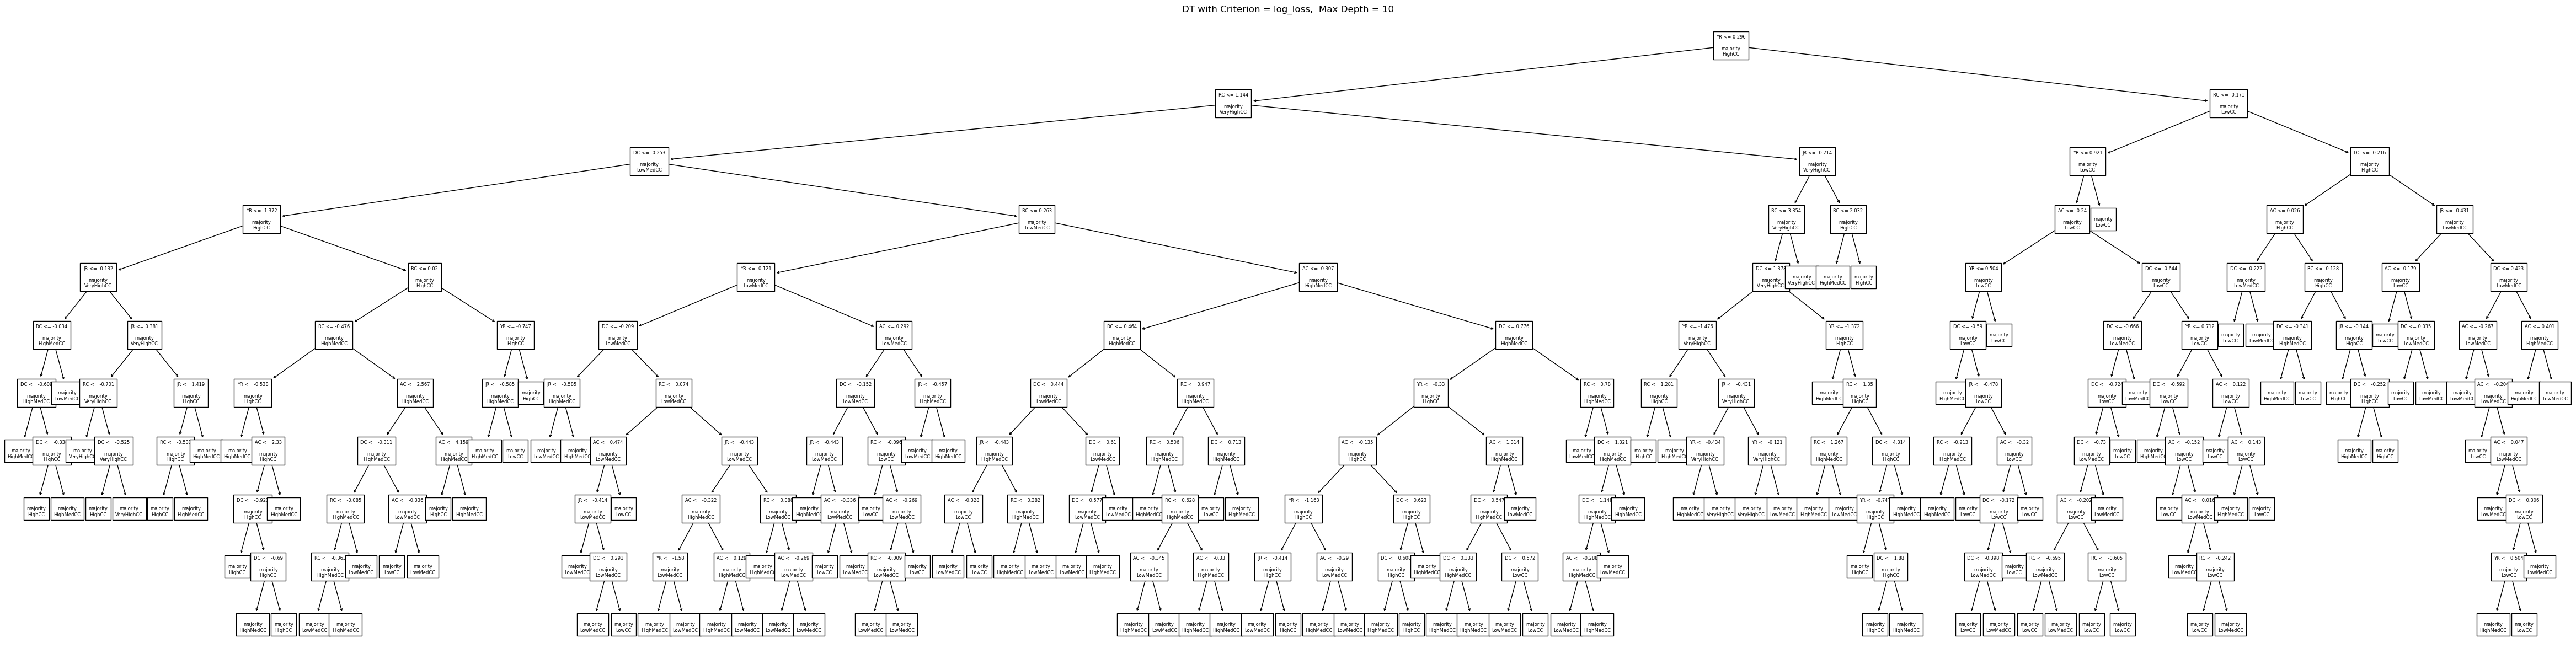

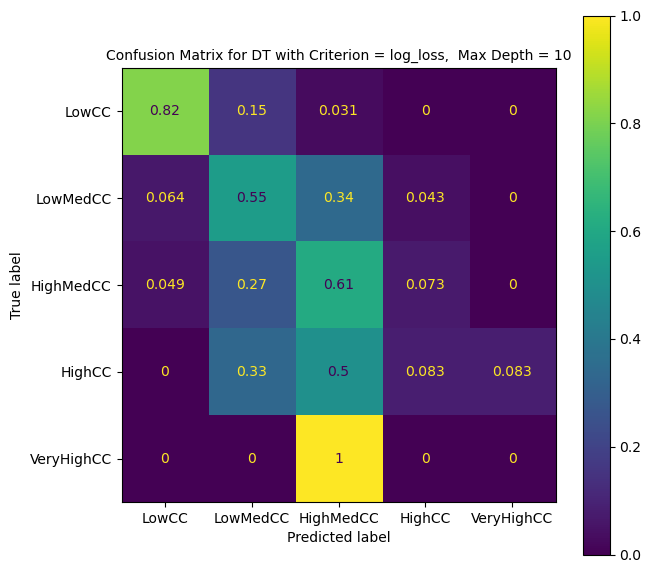

In [32]:
'''
Fit DTs with best params and other param sets
'''

def replace_text(obj, criterion='gini'):
    if type(obj) == matplotlib.text.Annotation:
        txt = obj.get_text()
        txt =  re.sub(f"{criterion}[^$]*\n", f"\n", txt)# re.sub(f"{criterion}[^$]*\n", "", txt)
        txt = re.sub("class = ", f"majority\n", txt)
        obj.set_text(txt)
    return obj

hyperparams = [(res.iloc[0]['criterion'], res.iloc[0]['max_depth']), ('gini', 5), ('log_loss', 10)]
for param_set in hyperparams:
    criterion = param_set[0]
    max_depth = param_set[1]
    model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
    model.fit(X_train, y_train)
    fig, ax = plt.subplots(1, 1, figsize=(max_depth*6, max_depth*1.5))
    plot_tree(model, ax=ax, fontsize=6, feature_names=['AC', 'YR', 'RC', 'DC', 'JR'], class_names=np.unique(data_DTC['citation_count_label']))#, label='None', impurity=False)
    ax.properties()['children'] = [replace_text(i, criterion) for i in ax.properties()['children']]
    fig.show()
    plt.savefig(f'../figs/DT_{criterion}_{max_depth}')
    ax.set_title(f'DT with Criterion = {criterion},  Max Depth = {max_depth}')
    preds = model.predict(X_test)
    print(f'Overall accuracy for criterion = {criterion}, Max Depth of {max_depth}: {np.round(metrics.accuracy_score(y_test, preds)*100,2)}%')
    cm = metrics.confusion_matrix(y_test, preds, labels=['LowCC', 'LowMedCC', 'HighMedCC', 'HighCC','VeryHighCC'], normalize='true')
    # print(y_test.value_counts(), print(np.sum(cm, axis=1)) # check that the number of each true label is correct, just for debugging
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['LowCC', 'LowMedCC', 'HighMedCC', 'HighCC', 'VeryHighCC'])
    fig, ax = plt.subplots(figsize=(7,7))
    disp.plot(ax=ax)
    ax.set_title(f'Confusion Matrix for DT with Criterion = {criterion},  Max Depth = {max_depth}', fontsize=10)


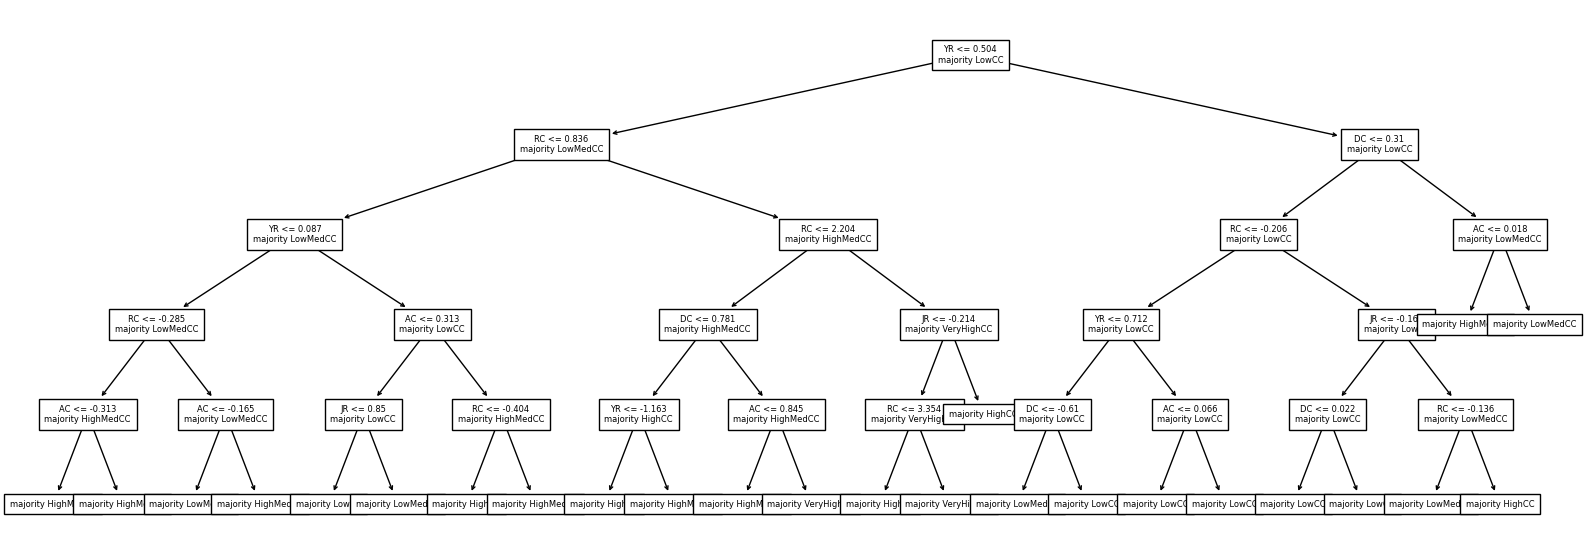

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import re
import matplotlib

# clf = RandomForestClassifier(random_state=0)
# iris = load_iris()
# clf = clf.fit(iris.data, iris.target)
# tree.plot_tree(clf.estimators_[0], ax=ax, feature_names= iris.feature_names, class_names=iris.target_names)

def replace_text(obj):
    if type(obj) == matplotlib.text.Annotation:
        txt = obj.get_text()
        txt = re.sub("gini[^$]*\n", "", txt)
        txt = re.sub("class = ", "majority ", txt)
        obj.set_text(txt)
    return obj
    

fig, ax = plt.subplots(figsize=(20,7))
model = DecisionTreeClassifier(criterion='gini', max_depth=5)
model.fit(X_train, y_train)
plot_tree(model, ax=ax, fontsize=6, feature_names=['AC', 'YR', 'RC', 'DC', 'JR'], class_names=np.unique(data_DTC['citation_count_label']))
ax.properties()['children'] = [replace_text(i) for i in ax.properties()['children']]
fig.show()

In [ ]:
# For requirenments

train_df = pd.DataFrame(X_train, columns=X.columns)
train_df['citation_count_label'] = y_train
test_df = pd.DataFrame(X_test, columns=X.columns)
test_df['citation_count_label'] = y_test
display(train_df)
display(test_df)

In [ ]:
'''

'''